In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score


font_path = '../Font/GmarketSansTTFMedium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

In [2]:
seoul = pd.read_csv('../Data/preprocessing/seoul_real_transcation_price.csv')

In [3]:
seoul.head(5)

,시도명,시군구명,관리기관,회사명,공장구분,단지명,설립구분,입주형태,보유구분,등록구분,...,지식산업센터명,대표업종,업종명,업종코드,차수,법인주소,필지수,공장주소,공장주소_지번,공장관리번호
0,서울특별시,종로구,서울특별시 종로구,남일문화 (주),개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 자하문로16길 8 (창성동),1,서울특별시 종로구 자하문로16길 8 (창성동),서울특별시 종로구 창성동 87-1번지,1.110000e+14
1,서울특별시,종로구,서울특별시 종로구,(주)에취.알.디,개별,,일반,해당없음,임대,등록변경,...,,33932,전시용 모형 제조업,33932,10,서울특별시 종로구 통의동 35-69번지,1,서울특별시 종로구 통의동 35-69번지,서울특별시 종로구 통의동 35-69번지,1.110000e+14
2,서울특별시,종로구,서울특별시 종로구,(주)코리아쉬핑가제트,개별,,일반,해당없음,자가,등록변경,...,,58113,일반 서적 출판업 외 3 종,"58,113,181,111,811,300,000",10,서울특별시 도봉구 창동 181-17번지 쌍용아파트 115-1902,1,서울특별시 종로구 자하문로2길 13-3 (통의동),서울특별시 종로구 통의동 35-6번지,1.110000e+14
3,서울특별시,종로구,서울특별시 종로구,삼영DP,개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 사직로 125 (적선동),1,서울특별시 종로구 사직로 125 (적선동),서울특별시 종로구 적선동 107-1번지,1.110000e+14
4,서울특별시,종로구,서울특별시 종로구,삼진기획,개별,,일반,해당없음,임대,등록변경,...,,18119,기타 인쇄업 외 1 종,"1,811,918,113",10,서울특별시 서대문구 홍제동 -번지 문화촌현대아파트 103-1101호,1,서울특별시 종로구 적선동 2번지,서울특별시 종로구 적선동 2번지,1.110000e+14


In [4]:
seoul.columns

Index(['시도명', '시군구명', '관리기관', '회사명', '공장구분', '단지명', '설립구분', '입주형태', '보유구분',
       '등록구분', '전화번호', '남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계',
       '생산품', '원자재', '공장규모', '용도지역', '지목', '용지면적', '제조시설면적', '부대시설면적', '건축면적',
       '지식산업센터명', '대표업종', '업종명', '업종코드', '차수', '법인주소', '필지수', '공장주소',
       '공장주소_지번', '공장관리번호'],
      dtype='object')

### 삭제할 칼럼
시도명, 시군구명, 관리기관, 회사명, 단지명, 전화번호, 법인주소, 필지수, 공장주소, 공장관리번호, 시

### 보류 칼럼 (일단 삭제)
생산품, 원자재, 업종명, 대표업종, 차수, 필지수

### 전처리 진행
용도지역, 업종코드 값 000 제거, 공장주소 지번 -> 동으로 쪼개기

In [5]:
seoul = seoul.drop(columns=['시도명', '시군구명', '관리기관', '회사명', '단지명', '전화번호', '법인주소', '필지수', '공장주소', '공장관리번호']) #1차
seoul = seoul.drop(columns=['생산품', '원자재', '업종명', '업종코드', '차수']) #2차

In [6]:
seoul.head(3)

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,공장주소_지번
0,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역/제2종일반주거지역/고도지구,대,238.00,57.12,69.44,126.56,,18111,서울특별시 종로구 창성동 87-1번지
1,개별,일반,해당없음,임대,등록변경,5,2,0,0,7,소기업,도시지역/주거지역/주거지역/,대,157.55,79.11,78.44,157.55,,33932,서울특별시 종로구 통의동 35-69번지
2,개별,일반,해당없음,자가,등록변경,12,12,0,0,24,소기업,도시지역/주거지역/주거지역/,대,160.30,92.40,67.90,160.30,,58113,서울특별시 종로구 통의동 35-6번지


## 시각화 함수 

In [7]:
def plot_value_counts(df = seoul, columns=None, max_categories=20):
    '''특정 컬럼들의 value_counts를 시각화하는 함수'''
    if columns is None:
        columns = df.columns

    for col in columns:
        if df[col].dtype == 'object':
            plt.figure(figsize=(10, 6))
            count_series = df[col].value_counts().nlargest(max_categories)
            sns.barplot(x=count_series.index, y=count_series.values, palette='viridis')
            plt.title(f'{col} - value_counts')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45)

            # 막대 끝에 라벨 추가
            for index, value in enumerate(count_series.values):
                plt.text(index, value, f'{value}', ha='center', va='bottom')

            plt.show()

### 공장주소_지번을 시, 구, 동으로 구분하기

In [8]:
address = seoul['공장주소_지번'].str.split(n=2, expand=True)
address[2] = address[2].str.split().str[0] #남은 부분에서 첫번째만 분리

print(address)

address.columns = ['시', '구', '동']
seoul = pd.concat([seoul, address[['시', '구', '동']]], axis=1)
seoul = seoul.drop(columns=['공장주소_지번', '시', '동'])


           0    1    2
0      서울특별시  종로구  창성동
1      서울특별시  종로구  통의동
2      서울특별시  종로구  통의동
3      서울특별시  종로구  적선동
4      서울특별시  종로구  적선동
...      ...  ...  ...
11635  서울특별시  강동구  천호동
11636  서울특별시  강동구  천호동
11637  서울특별시  강동구  천호동
11638  서울특별시  강동구  천호동
11639  서울특별시  강동구  천호동

[11640 rows x 3 columns]


In [9]:
seoul.head(3)

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,구
0,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역/제2종일반주거지역/고도지구,대,238.00,57.12,69.44,126.56,,18111,종로구
1,개별,일반,해당없음,임대,등록변경,5,2,0,0,7,소기업,도시지역/주거지역/주거지역/,대,157.55,79.11,78.44,157.55,,33932,종로구
2,개별,일반,해당없음,자가,등록변경,12,12,0,0,24,소기업,도시지역/주거지역/주거지역/,대,160.30,92.40,67.90,160.30,,58113,종로구


In [10]:
seoul.columns

Index(['공장구분', '설립구분', '입주형태', '보유구분', '등록구분', '남자종업원', '여자종업원', '외국인남자종업원',
       '외국인여자종업원', '종업원합계', '공장규모', '용도지역', '지목', '용지면적', '제조시설면적', '부대시설면적',
       '건축면적', '지식산업센터명', '대표업종', '구'],
      dtype='object')

### 지식산업센터명 n개 이하는 묶어버리기

In [11]:
value_counts_df = seoul['지식산업센터명'].value_counts().reset_index()
value_counts_df.columns = ['지식산업센터명', '빈도수']

# Display the DataFrame
print(value_counts_df.to_string(index=False))

                      지식산업센터명  빈도수
                              7232
                     SK트윈테크타워   98
                    대륭테크노타운8차   93
                   대륭테크노타운12차   92
                 벽산/경인디지털밸리2차   86
                     우림라이온스밸리   76
                    대륭테크노타운3차   65
                     현대지식산업센터   60
                    벽산디지털밸리5차   55
                       한신IT타워   54
                      한라시그마밸리   53
                        센터플러스   51
                   대륭테크노타운 5차   51
                      디지털엠파이어   50
                           SK   50
                     갑을그레이트밸리   50
                   대륭테크노타운 6차   50
                      호서대벤처타워   48
                   우림라이온스밸리2차   47
                  에이스하이엔드타워9차   46
                    에이스하이엔드타워   46
                에이스하이엔드타워 클래식   46
                    에스티엑스브이타워   45
                 에이스하이엔드8차(주)   45
                    벽산디지털밸리6차   43
                  에이스테크노타워 1차   43
                 에이스하이엔드타워10차   42
                    

In [12]:
# value_counts_df = seoul['지식산업센터명'].value_counts().reset_index()
# value_counts_df.columns = ['지식산업센터명', '빈도수']

# value_counts_df['지식산업센터명'] = value_counts_df.apply(lambda row: row['지식산업센터명'] if row['빈도수'] >= 2 else '기타', axis=1)

# seoul['지식산업센터명'] = seoul['지식산업센터명'].apply(lambda x: x if x in value_counts_df[value_counts_df['지식산업센터명'] != '기타']['지식산업센터명'].values else '기타')

In [13]:
seoul['지식산업센터명'].value_counts()

                7232
SK트윈테크타워          98
대륭테크노타운8차         93
대륭테크노타운12차        92
벽산/경인디지털밸리2차      86
                ... 
서울숲IT캐슬            1
에스비즈니스센터           1
ENH아파트형공장          1
아벨테크노              1
엠스테이트              1
Name: 지식산업센터명, Length: 227, dtype: int64

In [14]:
df_count = seoul['용도지역'].value_counts().reset_index()
df_count.columns = ['용도지역', '빈도수']

print(df_count.to_string(index=False))

                          용도지역  빈도수
              도시지역/공업지역/준공업지역/ 6104
          도시지역/주거지역/제2종일반주거지역/ 1143
             도시지역/상업지역/일반상업지역/  683
               도시지역/주거지역/주거지역/  651
          도시지역/주거지역/제3종일반주거지역/  628
             도시지역/상업지역/근린상업지역/  513
          도시지역/공업지역/준공업지역/고도지구  207
      도시지역/주거지역/제2종일반주거지역/기타지역  201
          도시지역/공업지역/준공업지역/기타지역  200
              도시지역/주거지역/준주거지역/  196
      도시지역/주거지역/제3종일반주거지역/미관지구  114
               도시지역/공업지역/공업지역/   97
          도시지역/주거지역/제1종일반주거지역/   84
      도시지역/주거지역/제2종일반주거지역/미관지구   67
         도시지역/상업지역/일반상업지역/방화지구   63
      도시지역/주거지역/제2종일반주거지역/고도지구   59
      도시지역/주거지역/제3종일반주거지역/기타지역   56
             도시지역/상업지역/중심상업지역/   50
         도시지역/상업지역/일반상업지역/기타지역   45
             도시지역/상업지역/유통상업지역/   36
         도시지역/상업지역/일반상업지역/미관지구   32
             도시지역/녹지지역/자연녹지지역/   26
도시지역/주거지역/제2종일반주거지역/지구단위1종수립지구   25
      도시지역/주거지역/제3종일반주거지역/고도지구   23
       도시지역/상업지역/일반상업지역/개발진흥지구   22
             도시지역/공업지역/일반공업지역/   20
                            

In [15]:
df_count.count()

용도지역    86
빈도수     86
dtype: int64

In [16]:
def simplify_land_use(land_use):
    land_use = land_use.strip() #문자열의 양쪽 공백 제거
    parts = land_use.split('/')
    if len(parts) >= 2:
        return '/'.join(parts[:2])  # 주요 카테고리 2개만 남김
    else:
        return land_use

# 용도지역 일반화 적용
df_count['용도지역_일반화'] = df_count['용도지역'].apply(simplify_land_use)

# 결과 출력
df_count = df_count['용도지역_일반화'].value_counts().reset_index()
df_count.columns = ['용도지역_일반화', '빈도수']


print(df_count.to_string(index=False))

         용도지역_일반화  빈도수
        도시지역/주거지역   41
        도시지역/상업지역   20
        도시지역/공업지역   15
        도시지역/녹지지역    6
      관리지역/계획관리지역    2
                     1
도시지역  도시지역  준공업지역    1


In [17]:
seoul['용도지역'] = seoul['용도지역'].apply(simplify_land_use)

In [18]:
value_counts_df_land = seoul['용도지역'].value_counts().reset_index()
value_counts_df_land.columns = ['용도지역', '빈도수']

value_counts_df_land['용도지역'] = value_counts_df_land.apply(lambda row: row['용도지역'] if row['빈도수'] >= 2 else '기타', axis=1)
seoul['용도지역'] = seoul['용도지역'].apply(lambda x: x if x in value_counts_df_land[value_counts_df_land['용도지역'] != '기타']['용도지역'].values else '기타')

In [19]:
seoul['용도지역'].value_counts()

도시지역/공업지역      6685
도시지역/주거지역      3391
도시지역/상업지역      1497
도시지역/녹지지역        40
                 19
관리지역/계획관리지역       7
기타                1
Name: 용도지역, dtype: int64

In [20]:
seoul

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,구
0,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역,대,238.00,57.12,69.44,126.56,,18111,종로구
1,개별,일반,해당없음,임대,등록변경,5,2,0,0,7,소기업,도시지역/주거지역,대,157.55,79.11,78.44,157.55,,33932,종로구
2,개별,일반,해당없음,자가,등록변경,12,12,0,0,24,소기업,도시지역/주거지역,대,160.30,92.40,67.90,160.30,,58113,종로구
3,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역,대,280.00,35.00,88.50,123.50,,18111,종로구
4,개별,일반,해당없음,임대,등록변경,7,2,0,0,9,소기업,도시지역/상업지역,대,122.30,159.93,18.00,177.93,,18119,종로구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11635,개별,일반,일반건축물,임대,등록변경,1,4,0,0,5,소기업,도시지역/주거지역,대,104.31,104.31,0.00,104.31,,14199,강동구
11636,개별,일반,해당없음,자가,등록변경,0,0,0,0,0,소기업,도시지역/주거지역,대,164.61,110.74,53.87,164.61,,33120,강동구
11637,개별,일반,일반건축물,임대,등록변경,7,0,0,0,7,소기업,도시지역/주거지역,대,125.28,114.28,11.00,125.28,,15121,강동구
11638,개별,일반,일반건축물,임대,신규등록,2,3,0,0,5,소기업,도시지역/주거지역,대,104.15,104.15,0.00,104.15,,13222,강동구


### encoding 진행
1. label embeding
2. int 형식
3. binary encoding


### Model
1. lgbm, xgboost 라벨 인코딩
2. knn - one hot encoding 진행
3. catboost의 경우 label encoding말고 자체적인 범주형 데이터 방식 따르기

### Preprocessing

In [21]:
seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11640 entries, 0 to 11639
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   공장구분      11640 non-null  object 
 1   설립구분      11640 non-null  object 
 2   입주형태      11640 non-null  object 
 3   보유구분      11640 non-null  object 
 4   등록구분      11640 non-null  object 
 5   남자종업원     11640 non-null  int64  
 6   여자종업원     11640 non-null  int64  
 7   외국인남자종업원  11640 non-null  int64  
 8   외국인여자종업원  11640 non-null  int64  
 9   종업원합계     11640 non-null  int64  
 10  공장규모      11640 non-null  object 
 11  용도지역      11640 non-null  object 
 12  지목        11640 non-null  object 
 13  용지면적      11640 non-null  float64
 14  제조시설면적    11640 non-null  float64
 15  부대시설면적    11640 non-null  float64
 16  건축면적      11640 non-null  float64
 17  지식산업센터명   11640 non-null  object 
 18  대표업종      11640 non-null  object 
 19  구         11640 non-null  object 
dtypes: float64(4), int64(5), obj

In [22]:
seoul.columns

Index(['공장구분', '설립구분', '입주형태', '보유구분', '등록구분', '남자종업원', '여자종업원', '외국인남자종업원',
       '외국인여자종업원', '종업원합계', '공장규모', '용도지역', '지목', '용지면적', '제조시설면적', '부대시설면적',
       '건축면적', '지식산업센터명', '대표업종', '구'],
      dtype='object')

In [23]:
object_columns = ['공장구분', '설립구분', '입주형태', '보유구분', '등록구분', '공장규모', '용도지역', '지목', '지식산업센터명', '대표업종', '구']
int_columns = ['남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계','용지면적', '제조시설면적', '부대시설면적', '건축면적']

In [24]:
seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11640 entries, 0 to 11639
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   공장구분      11640 non-null  object 
 1   설립구분      11640 non-null  object 
 2   입주형태      11640 non-null  object 
 3   보유구분      11640 non-null  object 
 4   등록구분      11640 non-null  object 
 5   남자종업원     11640 non-null  int64  
 6   여자종업원     11640 non-null  int64  
 7   외국인남자종업원  11640 non-null  int64  
 8   외국인여자종업원  11640 non-null  int64  
 9   종업원합계     11640 non-null  int64  
 10  공장규모      11640 non-null  object 
 11  용도지역      11640 non-null  object 
 12  지목        11640 non-null  object 
 13  용지면적      11640 non-null  float64
 14  제조시설면적    11640 non-null  float64
 15  부대시설면적    11640 non-null  float64
 16  건축면적      11640 non-null  float64
 17  지식산업센터명   11640 non-null  object 
 18  대표업종      11640 non-null  object 
 19  구         11640 non-null  object 
dtypes: float64(4), int64(5), obj

In [25]:
# object 타입 변환
for column in object_columns:
    seoul[column] = seoul[column].astype('object')

for column in int_columns:
    seoul[column] = seoul[column].astype('int')

In [26]:
seoul

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,구
0,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역,대,238,57,69,126,,18111,종로구
1,개별,일반,해당없음,임대,등록변경,5,2,0,0,7,소기업,도시지역/주거지역,대,157,79,78,157,,33932,종로구
2,개별,일반,해당없음,자가,등록변경,12,12,0,0,24,소기업,도시지역/주거지역,대,160,92,67,160,,58113,종로구
3,개별,일반,해당없음,임대,신규등록,0,0,0,0,0,소기업,도시지역/주거지역,대,280,35,88,123,,18111,종로구
4,개별,일반,해당없음,임대,등록변경,7,2,0,0,9,소기업,도시지역/상업지역,대,122,159,18,177,,18119,종로구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11635,개별,일반,일반건축물,임대,등록변경,1,4,0,0,5,소기업,도시지역/주거지역,대,104,104,0,104,,14199,강동구
11636,개별,일반,해당없음,자가,등록변경,0,0,0,0,0,소기업,도시지역/주거지역,대,164,110,53,164,,33120,강동구
11637,개별,일반,일반건축물,임대,등록변경,7,0,0,0,7,소기업,도시지역/주거지역,대,125,114,11,125,,15121,강동구
11638,개별,일반,일반건축물,임대,신규등록,2,3,0,0,5,소기업,도시지역/주거지역,대,104,104,0,104,,13222,강동구


In [27]:
## 특정 칼럼 값에서 주어진 임계값 보다 작으면 '기타'로 대체하는 함수
def replace_with_etc(df, column, threshold):
    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = [column, '빈도수']

    value_counts[column] = value_counts.apply(lambda row: row[column] if row['빈도수'] >= threshold else '기타', axis=1)

    df[column] = df[column].apply(lambda x: x if x in value_counts[value_counts[column] != '기타'][column].values else '기타')

    return df

In [28]:
# plot_value_counts(seoul)

In [29]:
seoul['공장구분'].value_counts()

개별    8114
계획    3526
Name: 공장구분, dtype: int64

In [30]:
# seoul = replace_with_etc(seoul, '설립구분', 428)

In [31]:
seoul['설립구분'].value_counts()

일반        8062
국가산업단지    3028
지식산업센터     427
일반산업단지      71
창업          52
Name: 설립구분, dtype: int64

In [32]:
seoul['입주형태'] = seoul['입주형태'].str.strip() # 공백제거
seoul['입주형태'].replace('', '해당없음', inplace=True)
seoul['입주형태'].fillna('해당없음', inplace=True)

In [33]:
seoul['입주형태'].value_counts()

해당없음     4357
일반건축물    2273
분양       1515
공장임대     1495
양수도      1325
임대사업자     346
기타        232
경매         80
일반토지       17
Name: 입주형태, dtype: int64

In [34]:
# seoul = replace_with_etc(seoul, '입주형태', 80)

In [35]:
seoul['입주형태'].value_counts()

해당없음     4357
일반건축물    2273
분양       1515
공장임대     1495
양수도      1325
임대사업자     346
기타        232
경매         80
일반토지       17
Name: 입주형태, dtype: int64

In [36]:
seoul['보유구분'].value_counts()

임대    6350
자가    5290
Name: 보유구분, dtype: int64

In [37]:
seoul['등록구분'].value_counts()

신규등록    5235
등록변경    3477
완료신고    2876
부분등록      52
Name: 등록구분, dtype: int64

In [38]:
seoul['공장규모'].value_counts()

소기업    11243
중기업      364
대기업       33
Name: 공장규모, dtype: int64

In [39]:
seoul['용도지역'].value_counts()

도시지역/공업지역      6685
도시지역/주거지역      3391
도시지역/상업지역      1497
도시지역/녹지지역        40
                 19
관리지역/계획관리지역       7
기타                1
Name: 용도지역, dtype: int64

In [40]:
seoul['지목'].value_counts()

대          6029
공장용지       5503
             33
답            24
학교용지         21
잡종지           8
대, 공장용지       5
도로            4
전             3
임야            3
창고용지          2
제방            1
대, 학교용지       1
하천            1
철도용지          1
사적지           1
Name: 지목, dtype: int64

In [41]:
seoul['지목'] = seoul['지목'].str.strip() # 공백제거
seoul['지목'].replace('', '해당없음', inplace=True)
seoul['지목'].fillna('해당없음', inplace=True)

In [42]:
# seoul = replace_with_etc(seoul, '지목', 2)
#pre_process

In [43]:
seoul['지목'].value_counts()

대          6029
공장용지       5503
해당없음         33
답            24
학교용지         21
잡종지           8
대, 공장용지       5
도로            4
전             3
임야            3
창고용지          2
제방            1
대, 학교용지       1
하천            1
철도용지          1
사적지           1
Name: 지목, dtype: int64

In [44]:
seoul['지식산업센터명'].value_counts()

                7232
SK트윈테크타워          98
대륭테크노타운8차         93
대륭테크노타운12차        92
벽산/경인디지털밸리2차      86
                ... 
서울숲IT캐슬            1
에스비즈니스센터           1
ENH아파트형공장          1
아벨테크노              1
엠스테이트              1
Name: 지식산업센터명, Length: 227, dtype: int64

In [45]:
seoul['지식산업센터명'] = seoul['지식산업센터명'].str.strip() # 공백제거
seoul['지식산업센터명'].replace('', '해당없음', inplace=True)
seoul['지식산업센터명'].fillna('해당없음', inplace=True)

In [46]:
seoul['지식산업센터명'].value_counts()

해당없음            7232
SK트윈테크타워          98
대륭테크노타운8차         93
대륭테크노타운12차        92
벽산/경인디지털밸리2차      86
                ... 
서울숲IT캐슬            1
에스비즈니스센터           1
ENH아파트형공장          1
아벨테크노              1
엠스테이트              1
Name: 지식산업센터명, Length: 227, dtype: int64

In [47]:
seoul['구'].value_counts()

금천구     3455
성동구     1357
구로구     1215
중구      1193
영등포구     845
강서구      645
송파구      428
중랑구      341
동대문구     265
강남구      228
서초구      209
광진구      174
종로구      166
도봉구      155
강동구      129
양천구      108
노원구      105
성북구      103
마포구      102
은평구       94
강북구       89
용산구       77
관악구       65
서대문구      52
동작구       40
Name: 구, dtype: int64

### in형 시각화 함수

In [48]:
def visualize_distribution(df, column):
    plt.figure(figsize=(18, 6))

    #히스토그램
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=50, kde=True)
    plt.title(f'Histogram of {column}')

    #박스 플롯
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'BoxPlot of {column}')

    plt.show()

## int 형 확인

In [49]:
## int형 확인 함수
def int_list(df, column):
    value_counts_df = df[column].value_counts().reset_index()
    value_counts_df.columns = [column, '빈도수']

    print(value_counts_df.to_string(index=False))

In [50]:
int_list(seoul, '남자종업원')

 남자종업원  빈도수
     2 1483
     3 1460
     4 1319
     5 1085
     1 1009
     6  712
     7  565
     8  502
     0  493
    10  419
     9  326
    12  240
    11  220
    13  177
    15  168
    14  126
    18  118
    20  114
    17   80
    16   75
    19   70
    30   58
    22   56
    25   53
    23   44
    21   40
    26   36
    24   35
    27   30
    28   30
    40   25
    35   23
    36   22
    45   20
    31   19
    38   18
    29   18
    33   18
    43   18
    50   15
    42   14
    32   14
    44   11
    39   10
    60   10
    34    9
    37    9
    47    8
    53    7
    62    7
    65    7
    55    6
    41    6
    67    5
    51    5
    83    5
    52    5
    54    5
    64    5
    79    5
    56    5
    49    5
    80    4
   100    4
    63    4
    90    4
    48    4
    70    4
    89    3
    58    3
    68    3
    59    3
    77    3
    66    2
   120    2
    75    2
   124    2
   191    2
    73    2
    84    2
    78    2
   135    2
    

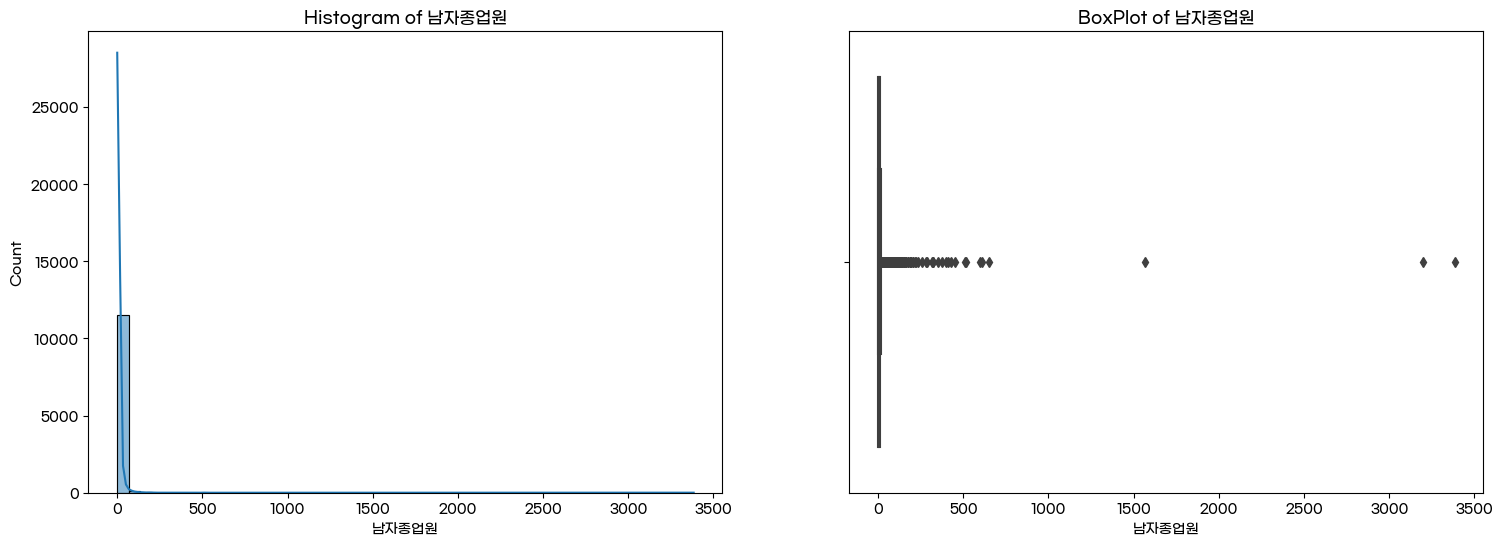

In [51]:
visualize_distribution(seoul, '남자종업원')

In [52]:
# ## 로그 변환
# def log_transform(df, column):
#     df[column] = df[column].apply(lambda x: np.log1p(x))
#     return df

In [53]:
## 이상치 제거
def remove_outlier(df, column, q1, q3):
    Q1 = df[column].quantile(q1)
    Q3 = df[column].quantile(q3)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [54]:
## 외국인 남자 종업원이상치 제거
def unifty_column(df, column, threshold):
    df.loc[df[column] >= threshold, column] = threshold
    return df

In [55]:
# seoul = log_transform(seoul, '남자종업원')

In [56]:
seoul['남자종업원'].value_counts()

2      1483
3      1460
4      1319
5      1085
1      1009
       ... 
104       1
600       1
114       1
324       1
82        1
Name: 남자종업원, Length: 157, dtype: int64

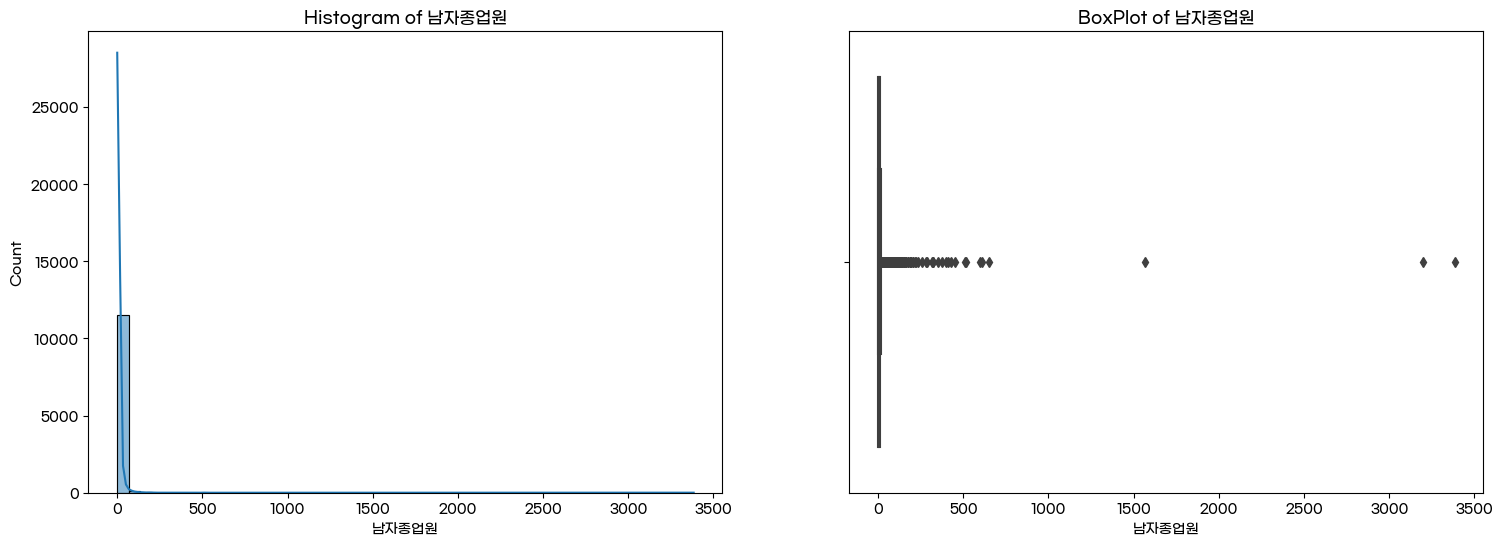

In [57]:
visualize_distribution(seoul, '남자종업원')

In [58]:
# seoul = remove_outlier(seoul, '남자종업원', 0.10, 0.95)
seoul = unifty_column(seoul, '남자종업원', 110)

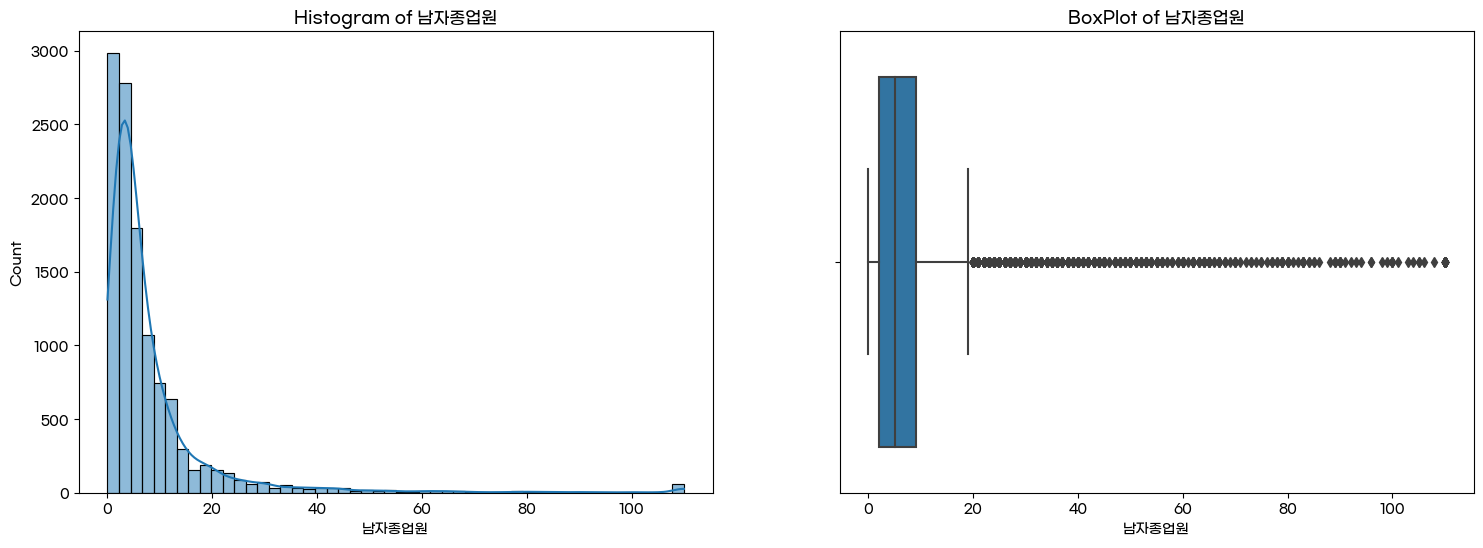

In [59]:
visualize_distribution(seoul, '남자종업원')

In [60]:
seoul['남자종업원'].value_counts()

2      1483
3      1460
4      1319
5      1085
1      1009
       ... 
71        1
91        1
81        1
104       1
82        1
Name: 남자종업원, Length: 105, dtype: int64

In [61]:
seoul['여자종업원'].value_counts()

1      3055
0      2476
2      1911
3      1090
4       688
       ... 
151       1
200       1
130       1
94        1
89        1
Name: 여자종업원, Length: 105, dtype: int64

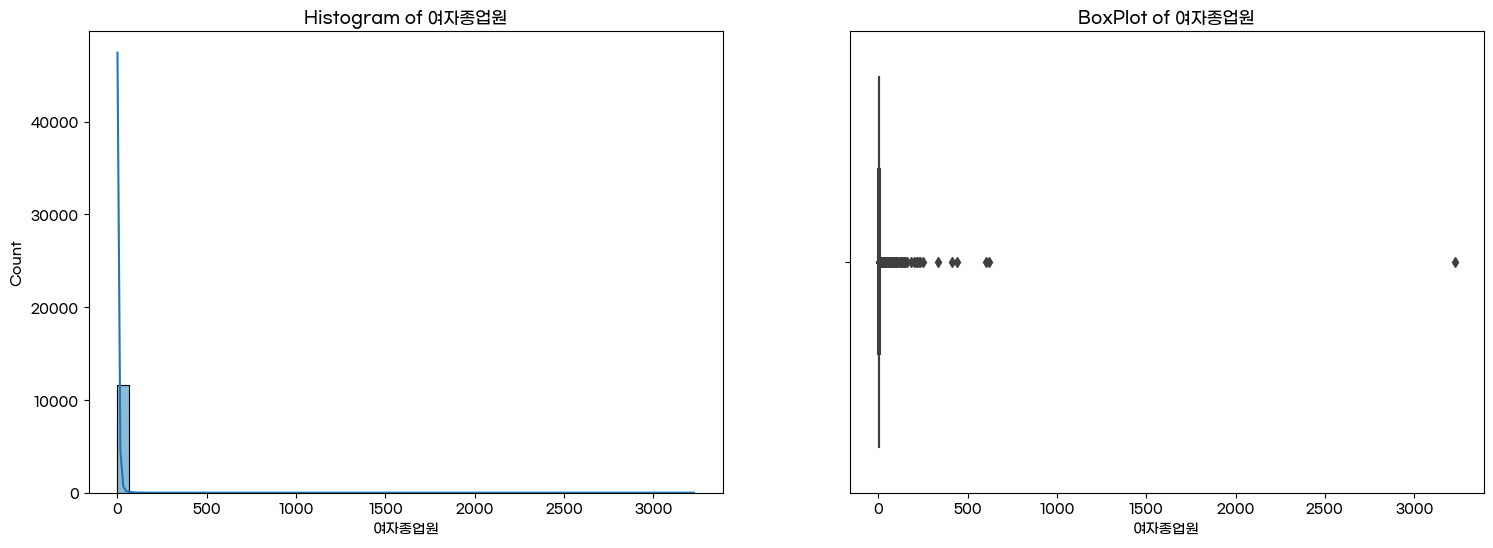

In [62]:
visualize_distribution(seoul, '여자종업원')

In [63]:
# seoul = remove_outlier(seoul, '여자종업원', 0.10, 0.95) 
# seoul = unifty_column(seoul, '여자종업원', 110)

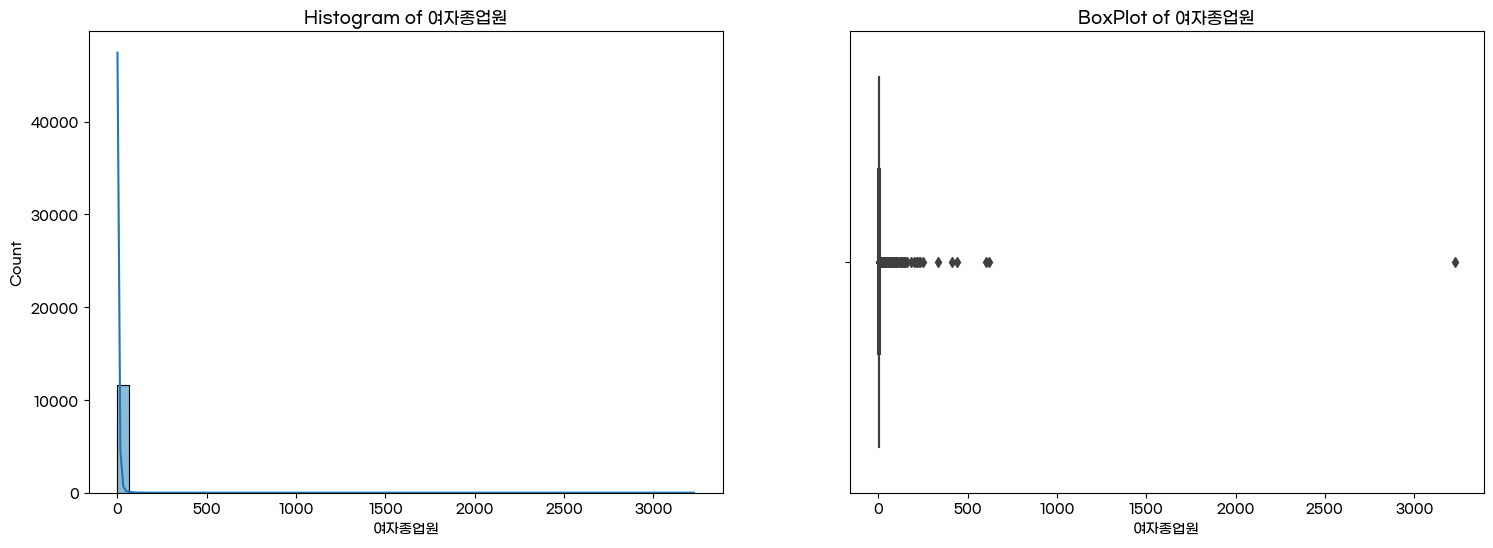

In [64]:
visualize_distribution(seoul, '여자종업원')

In [65]:
seoul['외국인남자종업원'].value_counts()

0     11363
1       127
2        49
3        26
4        19
5        14
6         7
8         6
10        6
7         4
11        3
9         3
21        3
13        2
12        2
71        1
14        1
17        1
15        1
23        1
16        1
Name: 외국인남자종업원, dtype: int64

In [66]:
# seoul = unifty_column(seoul, '외국인남자종업원', 6)

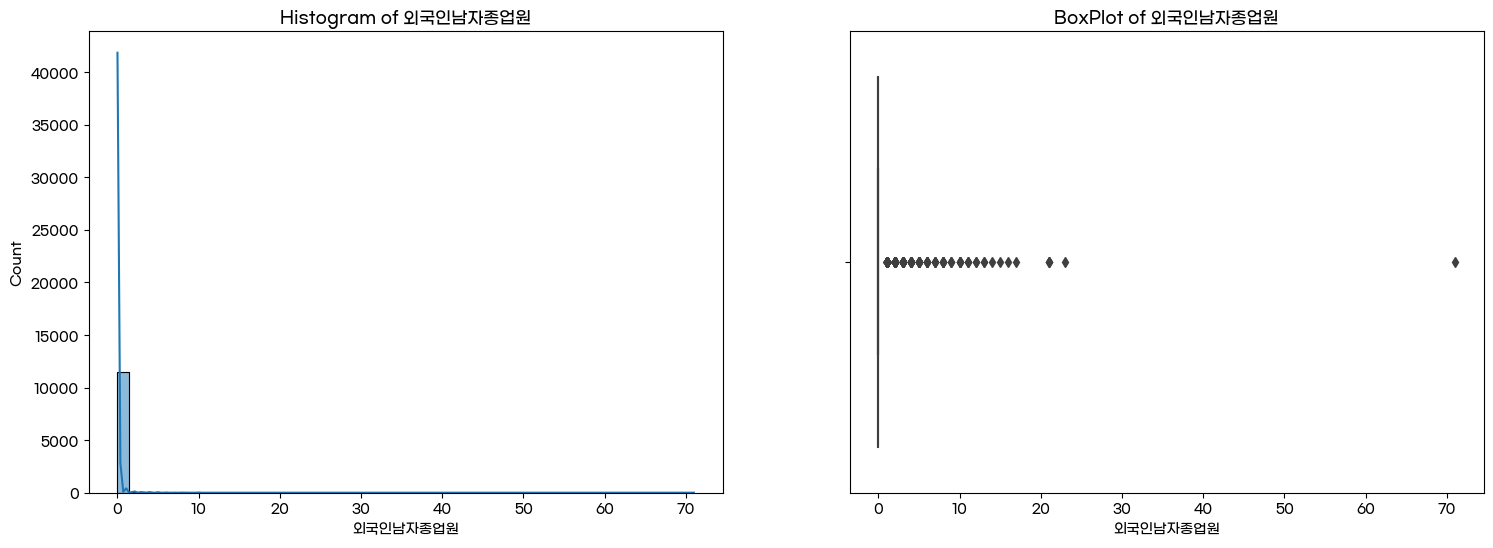

In [67]:
visualize_distribution(seoul, '외국인남자종업원')

In [68]:
seoul['외국인남자종업원'].value_counts()

0     11363
1       127
2        49
3        26
4        19
5        14
6         7
8         6
10        6
7         4
11        3
9         3
21        3
13        2
12        2
71        1
14        1
17        1
15        1
23        1
16        1
Name: 외국인남자종업원, dtype: int64

In [69]:
seoul['외국인여자종업원'].value_counts()

0      11538
1         54
2         23
3          6
4          5
5          3
6          2
8          2
10         2
13         1
129        1
64         1
17         1
19         1
Name: 외국인여자종업원, dtype: int64

In [70]:
# seoul = unifty_column(seoul, '외국인여자종업원', 7) #외국인 여자 종업원 7이상은 동일하다로 가도 됨

In [71]:
seoul['종업원합계'].value_counts()

4      1150
5      1130
3      1048
6       842
2       794
       ... 
101       1
209       1
500       1
450       1
111       1
Name: 종업원합계, Length: 188, dtype: int64

In [72]:
int_list(seoul, '종업원합계')

 종업원합계  빈도수
     4 1150
     5 1130
     3 1048
     6  842
     2  794
     7  745
     8  580
    10  562
     9  481
     1  394
    12  324
    11  315
    13  265
     0  252
    15  243
    14  232
    20  184
    16  156
    17  149
    18  133
    25  106
    19  100
    21   97
    30   94
    22   89
    24   74
    23   60
    35   51
    28   50
    26   47
    40   46
    27   46
    32   37
    34   33
    31   32
    33   31
    29   29
    45   26
    36   25
    50   24
    37   23
    38   21
    39   20
    48   18
    46   18
    44   17
    49   17
    42   16
    41   16
    54   14
    47   13
    56   13
    43   13
    67   13
    51   12
    60   12
    52    9
    80    9
    75    9
    65    9
    70    8
    55    8
    63    8
    58    7
    57    6
    82    6
    62    6
   100    6
   104    6
    84    5
    88    5
    53    5
    69    5
    92    4
   160    4
    86    4
   110    4
    59    4
   145    4
    85    4
    90    4
    64    3
    

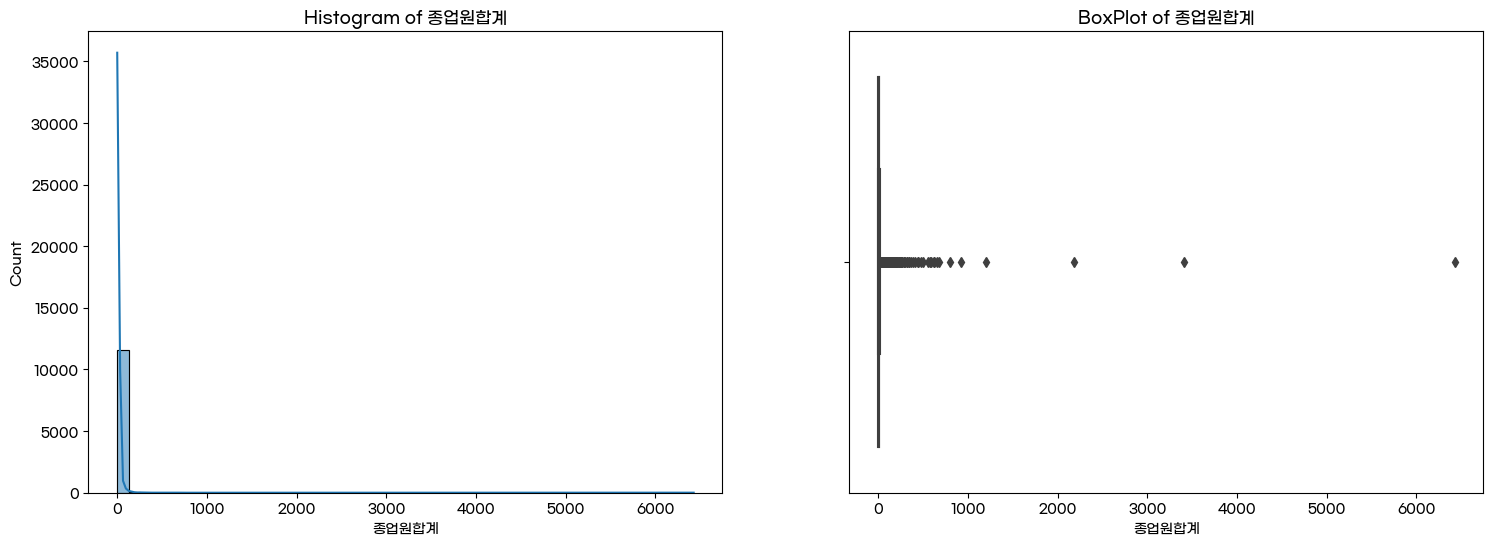

In [73]:
visualize_distribution(seoul, '종업원합계')

In [74]:
# seoul = remove_outlier(seoul, '종업원합계', 0.10, 0.95)
# seoul = unifty_column(seoul, '종업원합계', 250)

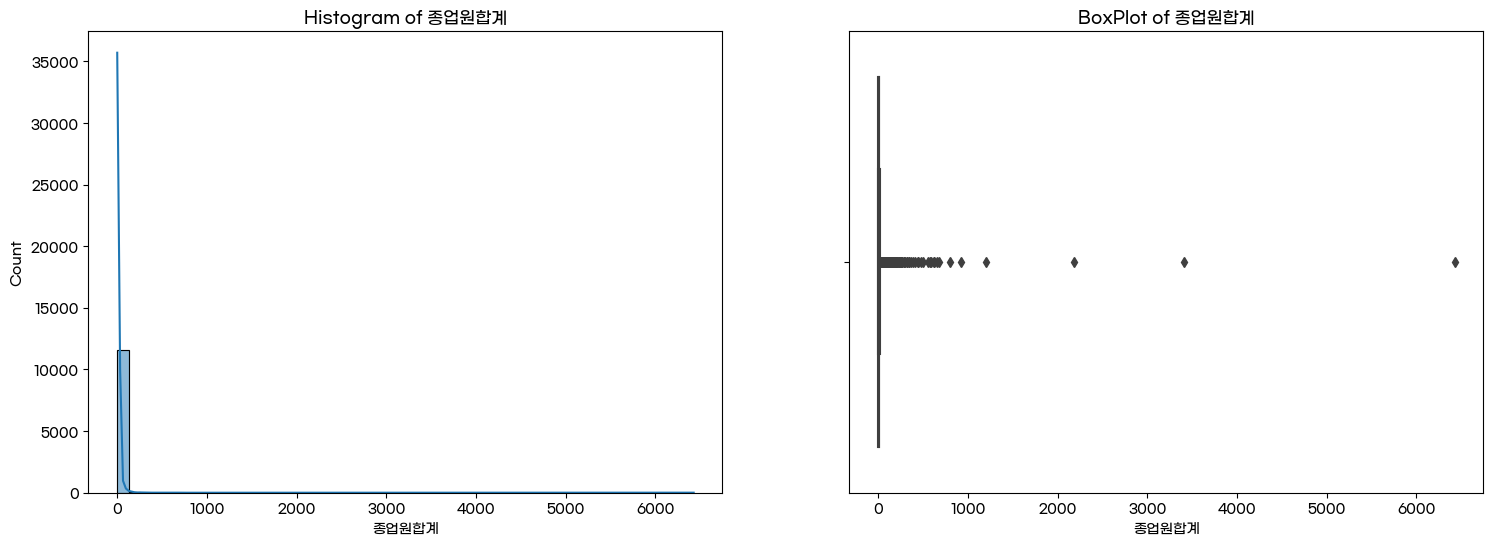

In [75]:
visualize_distribution(seoul, '종업원합계')

In [76]:
seoul['용지면적'].value_counts()

0       3169
33       111
34       107
66        88
32        82
        ... 
575        1
588        1
1865       1
804        1
382        1
Name: 용지면적, Length: 1195, dtype: int64

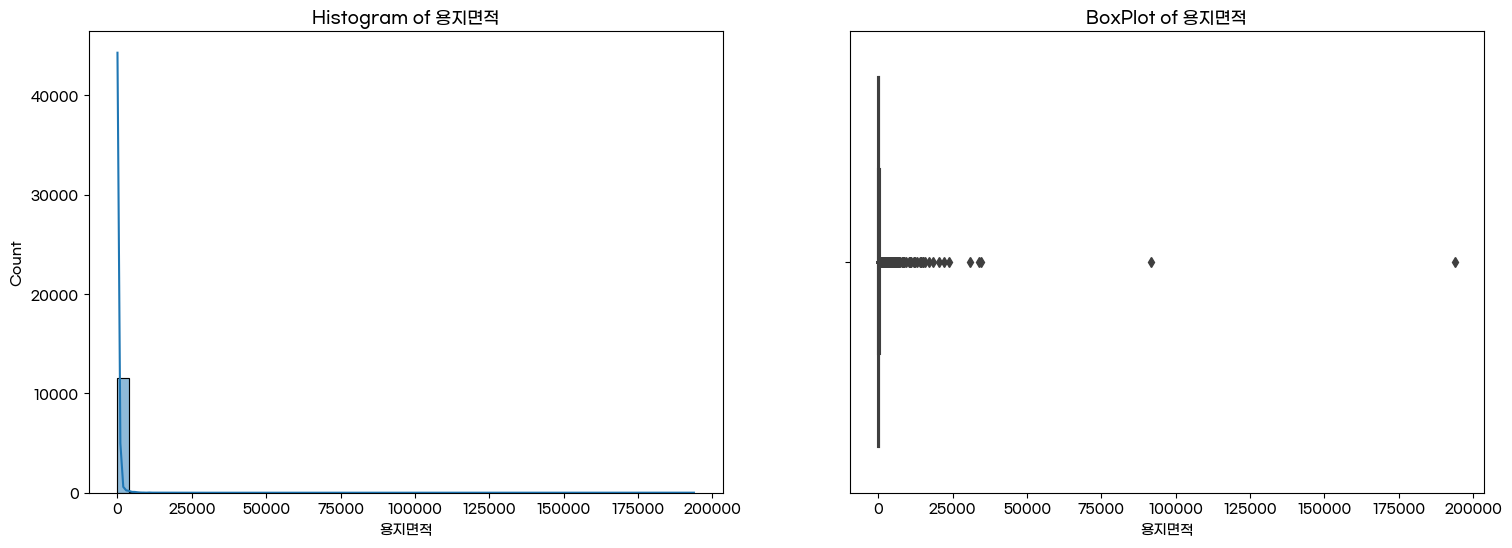

In [77]:
visualize_distribution(seoul, '용지면적')

In [78]:
# seoul = remove_outlier(seoul, '용지면적', 0.1, 0.80) #

In [79]:
# seoul = unifty_column(seoul, '용지면적', 4000) 

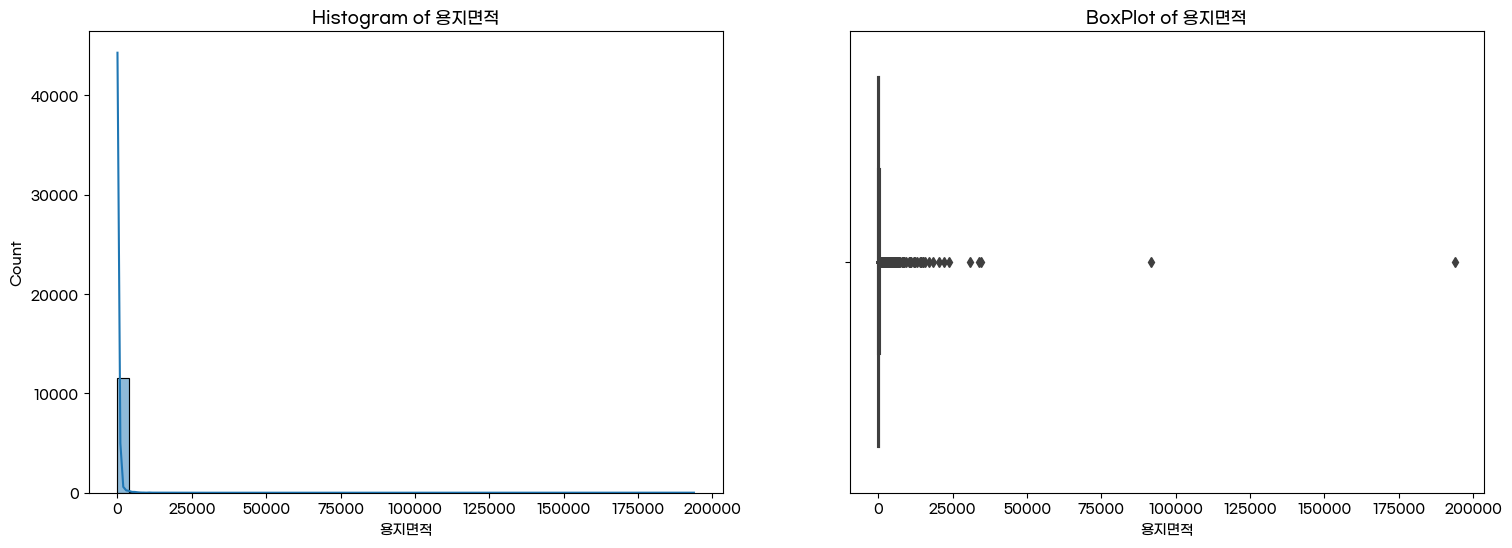

In [80]:
visualize_distribution(seoul, '용지면적')

In [81]:
seoul['용지면적'].value_counts()

0       3169
33       111
34       107
66        88
32        82
        ... 
575        1
588        1
1865       1
804        1
382        1
Name: 용지면적, Length: 1195, dtype: int64

In [82]:
seoul['제조시설면적'].value_counts()

132     151
100     145
33      138
50      136
60      126
       ... 
2236      1
704       1
592       1
1283      1
947       1
Name: 제조시설면적, Length: 1123, dtype: int64

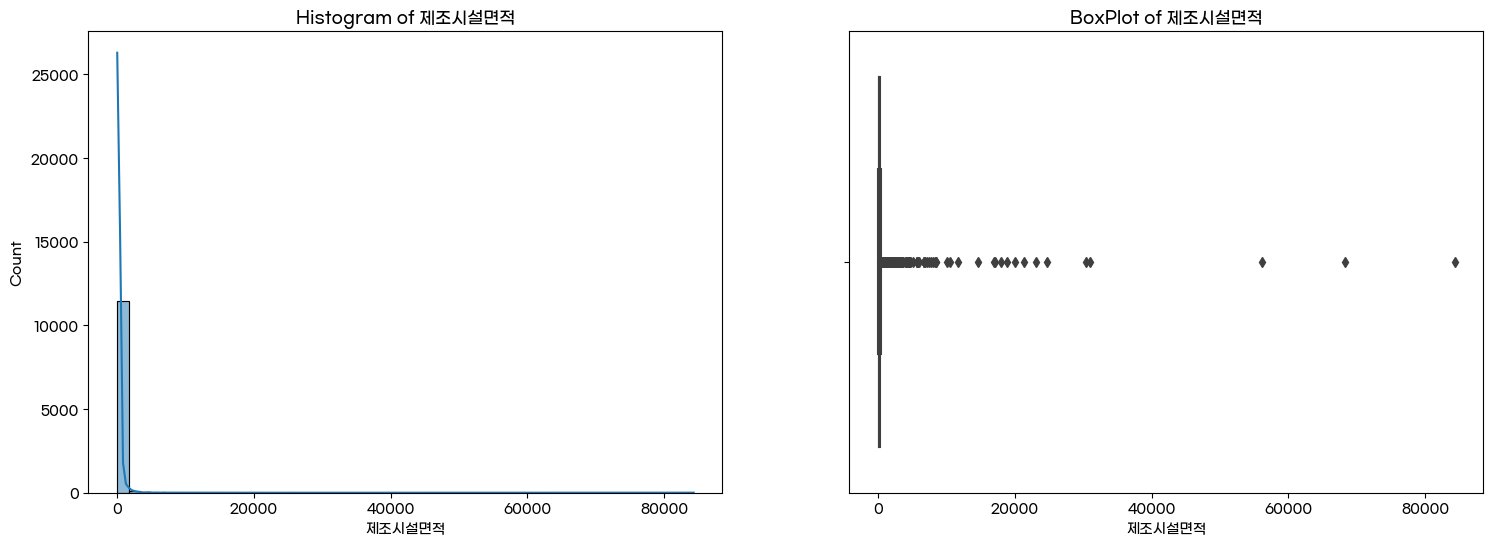

In [83]:
visualize_distribution(seoul, '제조시설면적')

In [84]:
seoul = remove_outlier(seoul, '제조시설면적', 0.05, 0.85) 

In [85]:
# seoul = unifty_column(seoul, '제조시설면적', 2000)

In [86]:
seoul['제조시설면적'].value_counts()

132    151
100    145
33     138
50     136
60     126
      ... 
661      1
605      1
581      1
694      1
711      1
Name: 제조시설면적, Length: 689, dtype: int64

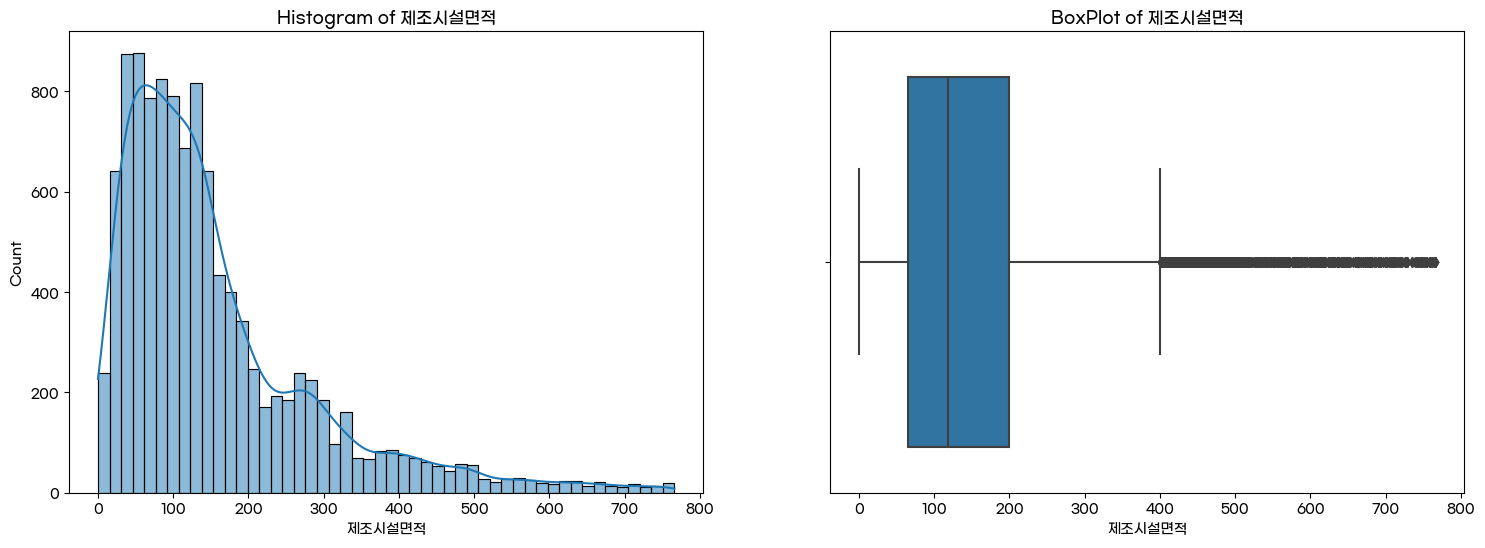

In [87]:
visualize_distribution(seoul, '제조시설면적')

In [88]:
seoul['부대시설면적'].value_counts()

0       2882
20       126
33       126
30       112
10       111
        ... 
507        1
749        1
481        1
353        1
4032       1
Name: 부대시설면적, Length: 662, dtype: int64

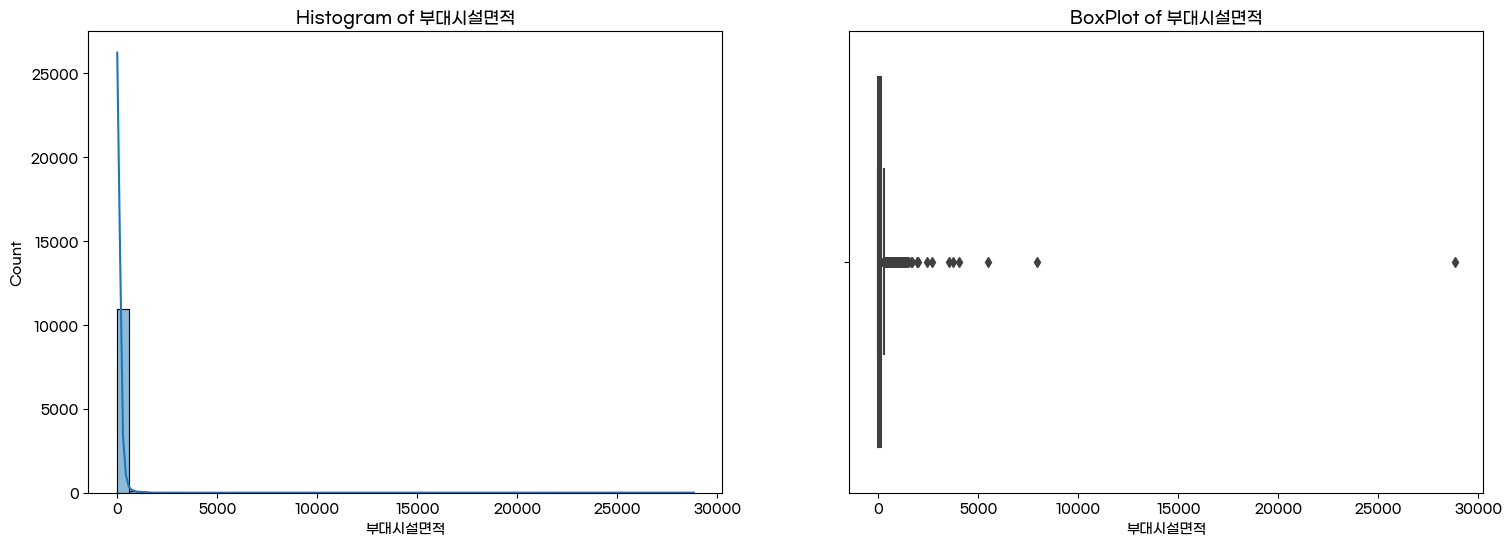

In [89]:
visualize_distribution(seoul, '부대시설면적')

In [90]:
# seoul = remove_outlier(seoul, '부대시설면적', 0.10, 0.95) 
seoul = unifty_column(seoul, '부대시설면적', 900)

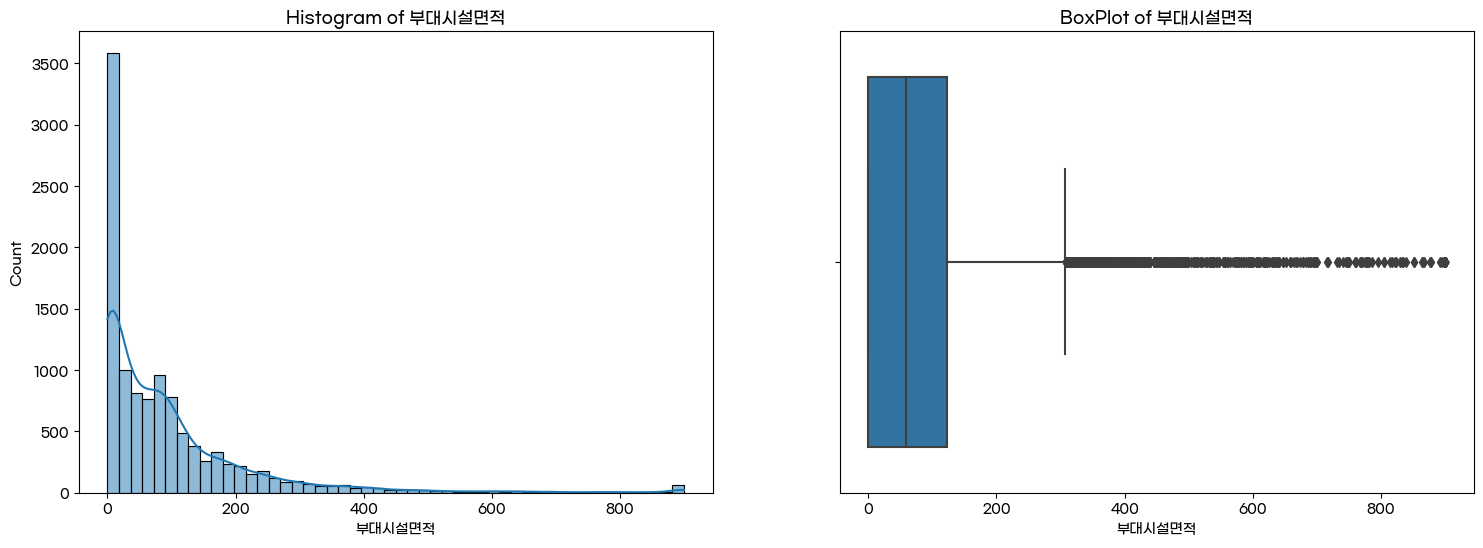

In [91]:
visualize_distribution(seoul, '부대시설면적')

In [92]:
seoul['건축면적'].value_counts()

132     110
66       87
165      85
220      84
198      80
       ... 
768       1
1845      1
743       1
1399      1
4230      1
Name: 건축면적, Length: 1053, dtype: int64

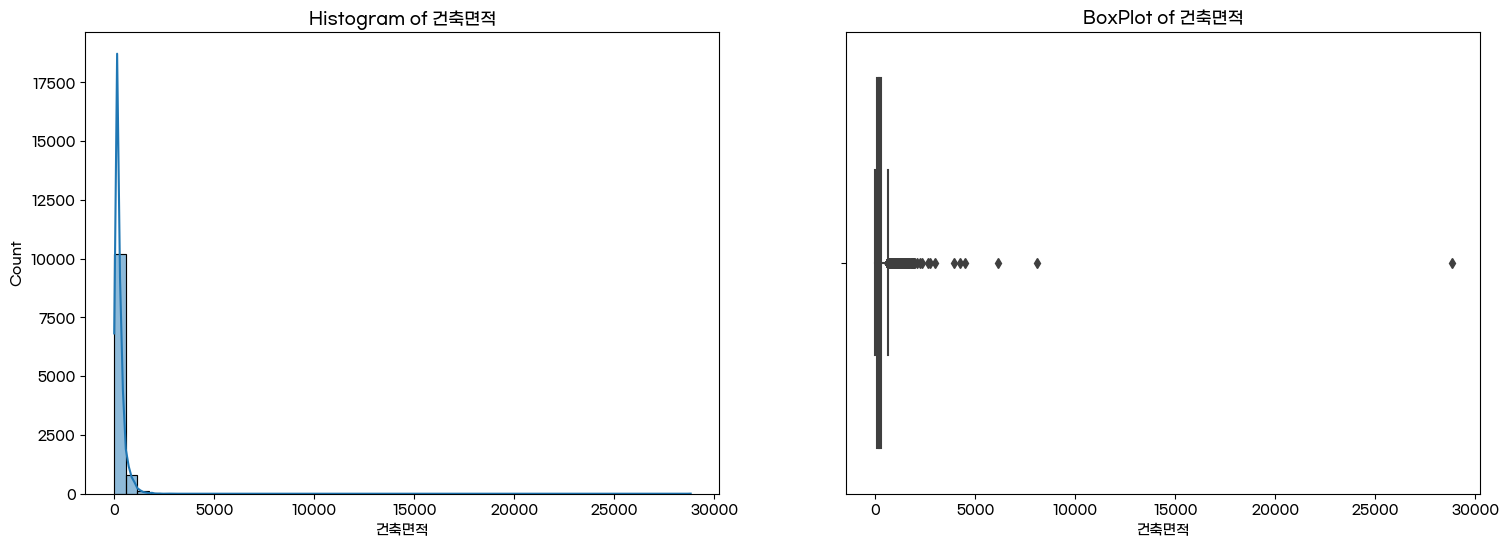

In [93]:
visualize_distribution(seoul, '건축면적')

In [94]:
seoul = remove_outlier(seoul, '건축면적', 0.05, 0.95) 

In [95]:
# seoul = unifty_column(seoul, '건축면적', 1800)

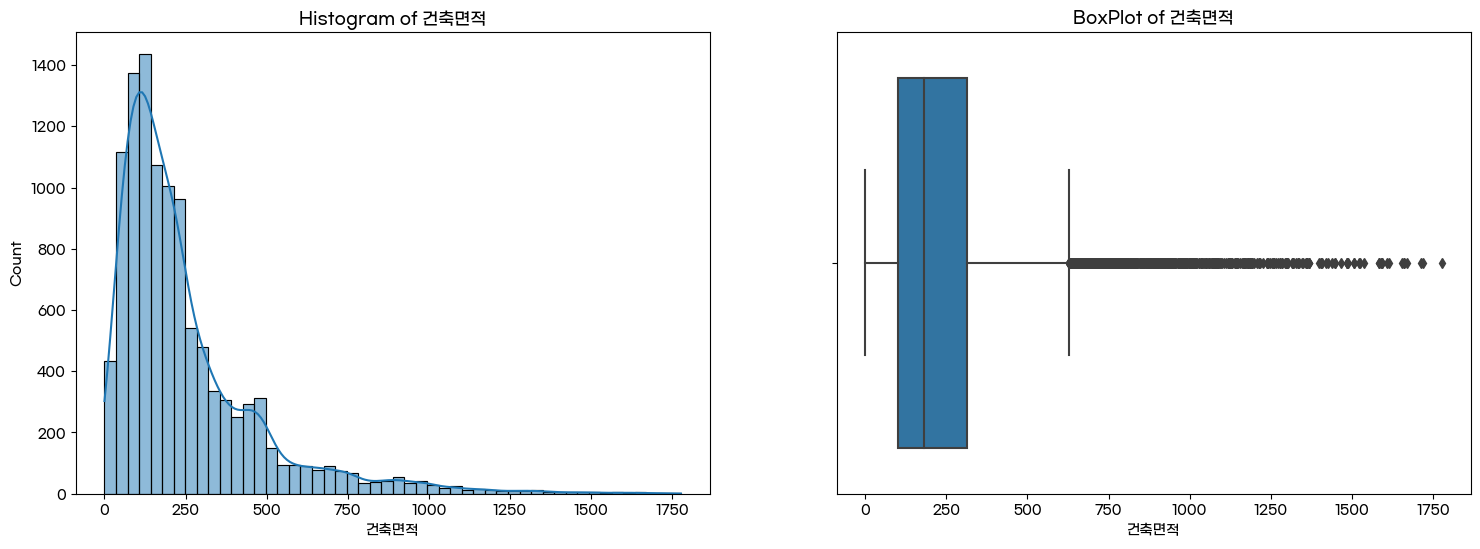

In [96]:
visualize_distribution(seoul, '건축면적')

In [97]:
seoul['건축면적'].value_counts()

132     110
66       87
165      85
220      84
198      80
       ... 
573       1
1583      1
1112      1
836       1
1257      1
Name: 건축면적, Length: 1029, dtype: int64

In [98]:
seoul.isnull().sum()

공장구분        0
설립구분        0
입주형태        0
보유구분        0
등록구분        0
남자종업원       0
여자종업원       0
외국인남자종업원    0
외국인여자종업원    0
종업원합계       0
공장규모        0
용도지역        0
지목          0
용지면적        0
제조시설면적      0
부대시설면적      0
건축면적        0
지식산업센터명     0
대표업종        0
구           0
dtype: int64

In [99]:
seoul['구'].value_counts()

금천구     3154
성동구     1270
중구      1184
구로구     1133
영등포구     828
강서구      616
송파구      424
중랑구      340
동대문구     263
강남구      228
서초구      208
광진구      174
종로구      165
도봉구      151
강동구      128
양천구      108
노원구      103
성북구      103
마포구      100
은평구       92
강북구       89
용산구       76
관악구       64
서대문구      51
동작구       39
Name: 구, dtype: int64

In [100]:
label_encoders = {}
for column in seoul.select_dtypes(include=['object']).columns:
    if column != '구':
        label_encoders[column] = LabelEncoder()
        seoul[column] = label_encoders[column].fit_transform(seoul[column])

# '구' 칼럼 라벨 인코딩
label_encoder_gu = LabelEncoder()
seoul['구'] = label_encoder_gu.fit_transform(seoul['구'])

X = seoul.drop(columns=['구'])
y = seoul['구']

In [101]:
print(X.shape, y.shape)

(11091, 19) (11091,)


In [102]:
X

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
0,0,1,8,0,2,0,0,0,0,0,1,6,2,238,57,69,126,222,104
1,0,1,8,0,0,5,2,0,0,7,1,6,2,157,79,78,157,222,391
2,0,1,8,1,0,12,12,0,0,24,1,6,2,160,92,67,160,222,416
3,0,1,8,0,2,0,0,0,0,0,1,6,2,280,35,88,123,222,104
4,0,1,8,0,0,7,2,0,0,9,1,5,2,122,159,18,177,222,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11635,0,1,5,0,0,1,4,0,0,5,1,6,2,104,104,0,104,222,67
11636,0,1,8,1,0,0,0,0,0,0,1,6,2,164,110,53,164,222,379
11637,0,1,5,0,0,7,0,0,0,7,1,6,2,125,114,11,125,222,76
11638,0,1,5,0,2,2,3,0,0,5,1,6,2,104,104,0,104,222,41


In [103]:
y.value_counts()

7     3154
15    1270
23    1184
6     1133
19     828
3      616
17     424
24     340
10     263
0      228
14     208
5      174
22     165
9      151
1      128
18     108
8      103
16     103
12     100
21      92
2       89
20      76
4       64
13      51
11      39
Name: 구, dtype: int64

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(7541, 19) (1886, 19) (1664, 19) (7541,) (1886,) (1664,)


In [105]:
## label encoding
from sklearn.preprocessing import LabelEncoder
categorical_features = list(X_train.dtypes[X_train.dtypes == 'object'.index])

# 라벨 인코딩 호기화
le = LabelEncoder()

# Label encoding 적용
for feature in categorical_features:
    X_train[feature] = le.fit_transform(X_train[feature])
    X_val[feature] = le.fit_transform(X_val[feature])
    X_test[feature] = le.fit_transform(X_test[feature])

In [107]:
print(X_train.info(), X.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7541 entries, 5781 to 1769
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   공장구분      7541 non-null   int32
 1   설립구분      7541 non-null   int32
 2   입주형태      7541 non-null   int32
 3   보유구분      7541 non-null   int32
 4   등록구분      7541 non-null   int32
 5   남자종업원     7541 non-null   int32
 6   여자종업원     7541 non-null   int32
 7   외국인남자종업원  7541 non-null   int32
 8   외국인여자종업원  7541 non-null   int32
 9   종업원합계     7541 non-null   int32
 10  공장규모      7541 non-null   int32
 11  용도지역      7541 non-null   int32
 12  지목        7541 non-null   int32
 13  용지면적      7541 non-null   int32
 14  제조시설면적    7541 non-null   int32
 15  부대시설면적    7541 non-null   int32
 16  건축면적      7541 non-null   int32
 17  지식산업센터명   7541 non-null   int32
 18  대표업종      7541 non-null   int32
dtypes: int32(19)
memory usage: 618.6 KB
None 공장구분        0
설립구분        0
입주형태        0
보유구분        0
등록구분       

In [108]:
# ## 1. standard scaer
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

In [109]:
# ## 2. MinMax scaer
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X) 

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

In [110]:
## 3. MinMax scaer
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X = scaler.fit_transform(X) 

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

In [111]:
# ## 4. MinMax scaer
# from sklearn.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X) 


# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

In [112]:
X_train

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
5781,1,0,4,1,3,2,1,0,0,3,1,3,0,32,135,101,236,57,261
3687,0,1,5,0,2,1,1,0,0,2,1,6,2,39,39,0,39,222,388
11277,0,1,3,1,2,2,2,0,0,4,1,5,2,155,60,95,155,88,232
4925,0,1,8,0,2,4,2,0,0,6,1,3,2,146,56,90,146,222,357
9852,0,1,5,0,2,5,0,0,0,5,1,3,2,0,175,0,175,222,317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,1,0,1,0,3,1,1,0,0,2,1,3,0,0,137,77,215,143,131
3358,0,1,5,0,2,1,2,0,0,3,1,6,2,99,66,33,99,222,59
7710,1,0,3,1,3,5,1,0,0,6,1,3,0,16,68,68,137,16,247
8554,1,3,4,1,3,1,1,0,0,2,1,3,0,21,87,64,151,94,105


In [113]:
from tarfile import XGLTYPE
#학습을 위한 라이브러리 세팅
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier

#평가지표
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



#모델 훈련 함수
def train_models(X_train, y_train):
    models = {
        "XGBClassifier": XGBClassifier(),
        "LGBMClassifier": LGBMClassifier(verbose = -1),
        # "CatBoostClassifier": CatBoostClassifier(verbose=0)  # verbose=0으로 설정하여 학습 중 메시지 출력을 최소화
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model

    return models


In [114]:
#train, val 시각화 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 결과 시각화 함수
def evaluate_models(models, X_train, y_train, X_val, y_val):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTrain Accuracy\tVal Accuracy\tTrain F1\tVal F1"
    print(header)
    print("-" * len(header))

    for name, model in models.items():
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)

        accuracy_train = accuracy_score(y_train, pred_train)
        accuracy_val = accuracy_score(y_val, pred_val)
        f1_train = f1_score(y_train, pred_train, average='macro')
        f1_val = f1_score(y_val, pred_val, average='macro')

        print(f"{name.ljust(max_name_length)}\t{accuracy_train:.4f}\t\t{accuracy_val:.4f}\t\t{f1_train:.4f}\t\t{f1_val:.4f}")

In [115]:
#모델 test 평가 함수
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# train, val 시각화 함수
def plot_accuracy_for_models(models, X_train, y_train, X_val, y_val):
    # 모델별 정확도 저장을 위한 리스트
    train_accuracy_list = []
    val_accuracy_list = []
    model_names = []

    # 각 모델별로 정확도 계산
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_val, val_pred)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        model_names.append(name)

    # 선형 그래프로 정확도 결과 시각화
    plt.figure(figsize=(15, 7))
    plt.plot(model_names, train_accuracy_list, marker='o', label='Training Accuracy')
    plt.plot(model_names, val_accuracy_list, marker='o', label='Validation Accuracy')

    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Different Models')
    plt.legend()

    plt.show()

In [116]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve, auc

def plot_auc_pr_curve(models, X_val, y_val):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        # 모델에 따라 predict_proba 또는 decision_function을 사용해야 할 수 있음
        if hasattr(model, "predict_proba"):
            probas_pred = model.predict_proba(X_val)[:, 1]
        else:  # 예를 들어 SVM과 같은 경우
            probas_pred = model.decision_function(X_val)

        precision, recall, _ = precision_recall_curve(y_val, probas_pred)
        auc_score = auc(recall, precision)

        plt.plot(recall, precision, label=f'{name} (AUC-PR = {auc_score:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Different Models')
    plt.legend()
    plt.show()

In [117]:
#모델 훈련
import matplotlib.pyplot as plt

# 모델 test 평가 함수
def evaluate_models_on_test(models, X_test, y_test):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Test Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTest Accuracy\t\tTest F1-Score"
    print(header)
    print("-------------------------------------------------------------------------------------")

    for name, model in models.items():
        pred_test = model.predict(X_test)

        accuracy_test = accuracy_score(y_test, pred_test)
        f1_score_test = f1_score(y_test, pred_test, average='macro')

        print(f"{name.ljust(max_name_length)}\t{accuracy_test:.4f}\t\t{f1_score_test:.4f}")

In [118]:
#모델 훈련
models = train_models(X_train, y_train)

In [119]:
#모델 성능평가
evaluate_models(models, X_train, y_train, X_val, y_val) #pre_process

Model Performance Evaluation:

Model          	Train Accuracy	Val Accuracy	Train F1	Val F1
-----------------------------------------------------------
XGBClassifier  	0.9993		0.6341		0.9996		0.2991
LGBMClassifier 	0.9992		0.6432		0.9997		0.3011


In [120]:
# plot_auc_pr_curve(models, X_val, y_val)

#결과 시각화
# plot_accuracy_for_models(models, X_train, y_train, X_val, y_val)

In [121]:
#모델 test평가
evaluate_models_on_test(models, X_test, y_test)

Model Test Performance Evaluation:

Model          	Test Accuracy		Test F1-Score
-------------------------------------------------------------------------------------
XGBClassifier  	0.6587		0.3474
LGBMClassifier 	0.6653		0.3546


In [122]:
# plot_auc_pr_curve(models, X_test, y_test)

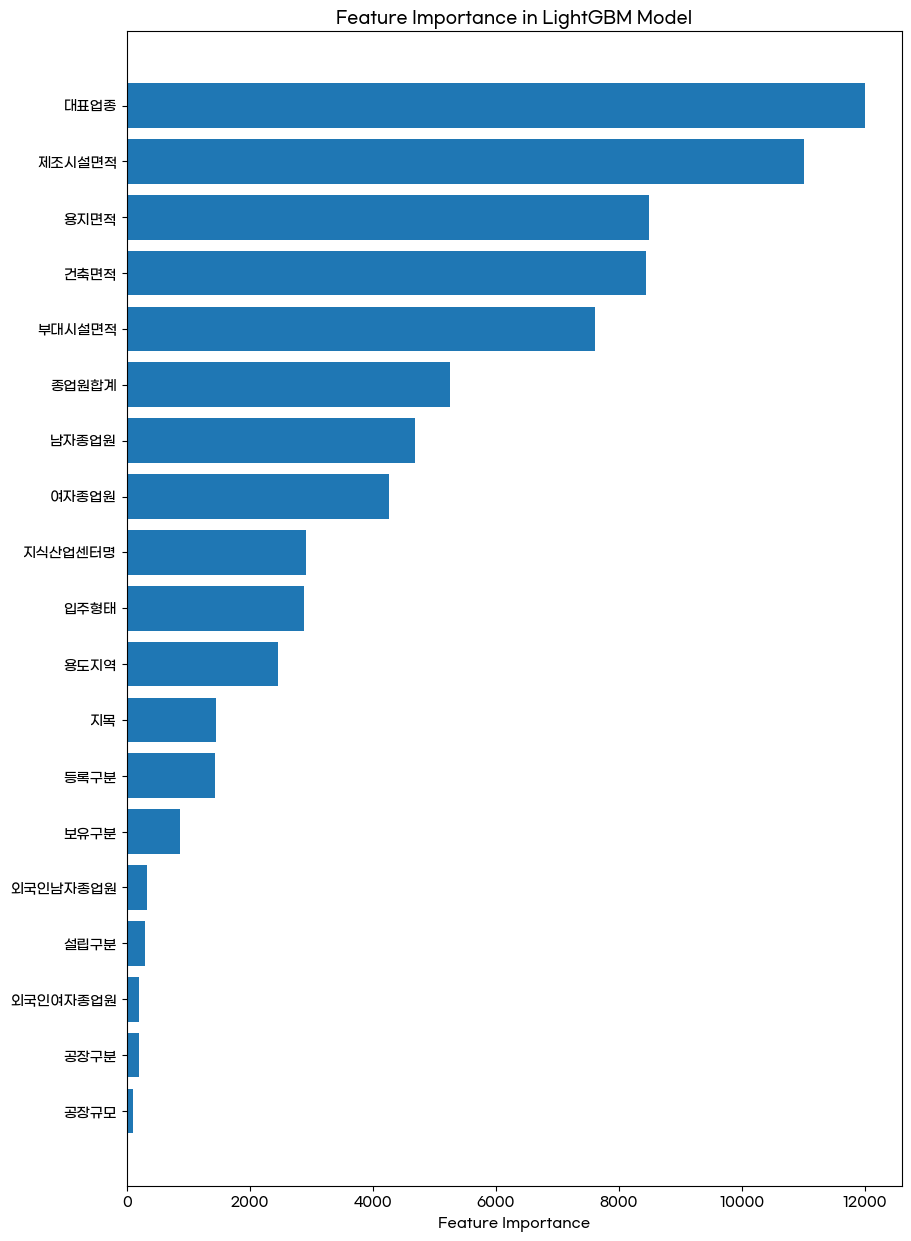

In [123]:
import matplotlib.pyplot as plt

# 데이터셋의 특성(열) 이름을 가져옵니다.
features = X_train.columns

# LightGBM 모델의 특성 중요도를 가져오고 정렬합니다.
lgbm_model = models['LGBMClassifier']
feature_importances = lgbm_model.feature_importances_
sorted_idx = feature_importances.argsort()

# 그래프 크기 설정
plt.figure(figsize=(10, 15))

# 특성 중요도를 시각화합니다.
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in LightGBM Model')
plt.show()


In [124]:
# import pandas as pd
# import folium
# import ast

# # 데이터의 업종코드를 리스트 형태로 변환 (문자열 형식 검사 및 변환)
# def safe_literal_eval(val):
#     try:
#         return ast.literal_eval(val)
#     except (ValueError, SyntaxError):
#         return val

# seoul['업종코드'] = seoul['업종코드'].apply(safe_literal_eval)

# # 각 업종코드 별로 시, 구, 동을 분류
# exploded_data = seoul.explode('업종코드')

# # 시각화를 위해 데이터를 집계
# location_counts = exploded_data.groupby(['시', '구', '동', '업종코드']).size().reset_index(name='count')

# # 서울특별시만 필터링
# seoul_data = location_counts[location_counts['시'] == '서울특별시']

# # 서울 구의 중심 좌표 데이터 준비 (샘플 데이터로 예시)
# # 실제로는 구별 중심 좌표를 정확히 입력해야 합니다
# seoul_gu_coords = {
#     '종로구': [37.573050, 126.979189],
#     # 다른 구들의 중심 좌표도 입력
# }

# # 지도 생성
# seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# # 업종코드별로 다른 색상으로 구별하여 표시
# for index, row in seoul_data.iterrows():
#     gu = row['구']
#     if gu in seoul_gu_coords:
#         folium.CircleMarker(
#             location=seoul_gu_coords[gu],
#             radius=5 + row['count'],  # count에 비례한 크기
#             color='blue',  # 임의 색상
#             fill=True,
#             fill_color='blue',
#             popup=f"업종코드: {row['업종코드']}\nCount: {row['count']}"
#         ).add_to(seoul_map)

# # 지도 표시
# seoul_map.save('seoul_industry_map.html')
